# 16.413 Final Project: Convex Risk Bounded Continuous-Time Trajectory Planning for a Europa Lander

Julia Briden (jbriden@mit.edu)
Kota Kondo (kkondo@mit.edu)
Lakshay Sharma (lakshays@mit.edu)
Nick Rober (nrober@mit.edu)
Youngjae Min (youngj0@mit.edu)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from mpl_toolkits import mplot3d
from sympy import *

## 1. Problem Statement

The year is 2048 and alien life has been detected under the ice of Europa! In the interest of getting to know our newly discovered neighbors, NASA has decided to dispatch a highly specialized fleet of vehicles to the Gallilean moon. The mission will consist of (i) an autonomous underwater vehicle (AUV) designed to slowly glide to Europa's sea floor while transmitting data via an optical fiber cable to a rover on the surface, (ii) a surface rover designed to ferry the underwater vehicle from a safe landing site to an appropriate insertion site (i.e. vapor plume outburst location), and (iii) an orbiter, capable of relaying signals from the rover and providing high-resolution imagery to map the surface.

![alt text](environment_basic.jpg "Europa Lander mission concept")

As part of NASA's Jet Propulsion Laboratory, our team has been tasked with creating the trajectory generation algorithm for the surface vehicle. The goal for the rover is to navigate from a safe landing site which is flat and free of obstacles to the AUV's insertion point, which has relatively thin ice and may be surrounded by uncertain hazards. We have access to global map data within the field of operation, allowing us to formulate the trajectory generation problem as an infinite horizon mixed-integer nonlinear programming problem. We will solve this optimization problem using scipy.minimize and the Bernstein polynomial library BEBOT. To provide additional autonomy capabilities and give the optimization algorithm a good chance of finding a feasible solution, we will initilize the optimizer using RRT* to form an initial guess of the optimal trajectory.

### Formulation

Generally, this problem can be stated as an optimal control problem in the form of

***
<font size="3"><h1><center>$\underset{x(t)\in\mathbb{R}^{n_x},\;u(t)\in\mathbb{R}^{u_n}}{\text{minimize}}\quad E(x(0),\;x(1))+\int_{0}^{1}F(x(t),u(t))dt$ <div style="text-align: right"> (1) </div><br> $\begin{align} & \text{subject to} \quad \quad \\  \\ &\dot{x} = f(x(t),\;u(t)),\quad \forall t\in[0,1] \\ & e(x(0),\;x(1)) = 0, \\ & h(x(t),\;u(t)) \leq 0,\quad \forall t\in[0,1] \end{align}$</center></h1></font>
***

However, this is a difficult problem to solve. We can simplify it by considering that our system can be modelled using the common unicycle model:

***
<font size="3"><h1><center>$\dot{x} = \begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \\ \dot{\phi} \end{bmatrix} = \begin{bmatrix} V \cos(\phi) \\ V \sin(\phi) \\ \omega \end{bmatrix}$</center></h1></font>
***

which is differentially flat. In this case, that is helpful because it means we can determine the inputs $V$ and $\omega$ directly from $x_1$ and $x_2$. Additionally, we can approximate $x(t)$ (the optimal trajectory) using a  Bernstein polynomial, which takes the form 

***
<font size="3"><h1><center>$x_N(t) = \sum_{i=0}^N \bar{x}_{i,N}b_{i,N}(t)$</center></h1></font>
***

where $\bar{x}_N = [\bar{x}_{0,N},\; ...,\; \bar{x}_{N,N}] \in \mathbb{R}^{n_x \times (N+1)}$, is a vector of control points for the Bernstein polynomial and 

***
<font size="3"><h1><center>$b_{i,N}(t) = \begin{pmatrix}N \\ i\end{pmatrix}t^i(1-t)^{N-i},\quad \begin{pmatrix}N \\ i\end{pmatrix} = \frac{N!}{i!(N-i)!}$</center></h1></font>
***

The use of Bernstein polynomials allows us to formulate the problem as a finite-dimensional optimization problem (choose N control points), rather than an infinite dimensional optimization problem. Additionally, Bernstein polynomials are fixed at the endpoints, (i.e. $x_N(t_0) = \bar{x}_{0,N}$ and $x_N(t_f) = \bar{x}_{N,N}$, allowing us to remove the equality constraint from (1). The fact that the model is differentially flat allows us to remove $u(t)$, and the convex hull property of Bernstein polynomials allows us to only evaluate the control points $\{x_{0,N}, ..., x_{N,N}\}$ for satisfaction of the inequality constraints. Thus, the simplified problem becomes

***
<font size="3"><h1><center>$\underset{\bar{x}_N}{\text{minimize}}\quad E(\bar{x}_{0,N},\;\bar{x}_{N,N})+\int_{0}^{1}F(x_N(t))dt$ <div style="text-align: right"> (2) </div><br> $\begin{align} & \text{subject to} \quad & \quad \\ & \|\dot{x}_N(t_i) - f(x_N(t_i)\| \leq 0, & \forall i \in \{0, 1, ..., N\} \\ & h(\bar{x}_{i,N}) \leq 0, & \forall i \in \{0, 1, ..., N\} \end{align}$</center></h1></font>
***

Finally, to address the inequality constraints $h(\bar{x}_{i,N})$, we list the necessary constraints on the system as

- Collision avoidance constraints (addressed below)
- Maximum and minimum speed constraints
- Maximum and minimum angular rate constraints

and plan to use total path length as the cost function to minimize the distance required by the rover to travel to the AUV insertion point.


From a practical standpoint, the scipy function minimize() can be used to solve problem (2). However, it requires an initial guess of the optimal trajectory as a starting point from which to begin using gradient descent. This guess warrants some consideration as it can have a large influence on the output of the function: one initial guess may give a good answer, while another may give local minima or even fail to converge to a solution. One option to generate this initial guess is to linearly interpolate between the initial and final positions. However it is often beneficial to give an initial guess which satisfies the system's constraints, which may not be the case if an obstacle lies on the straightline path between the initial and final positions. Thus, we plan to use RRT* as a fast way to generate what is hopefully a good initial guess.

Source: https://arxiv.org/pdf/1812.06132.pdf




## 2. Risk Contours

Risk contours are defined as the set of all points in uncertain environments with guaranteed bounded risk. We will use risk contours in finding optimal trajectories. 

For simplicity we incorporate only static risk contours into our problem, not dynamic contours, and replace probabilistic constraint with deterministic constraint in terms of x (use inner approximation of probabilisitic constraint to bound risk), which lead to rational polynomial representation.

### How to construct risk contours

Define $\chi \in \mathbb{R}^2$ as an uncertain environment where our ground robot explores and $\chi_{obs_{i}}(\omega_i) \subset \chi$, for $i = 1, ..., n_{o_{s}}$ as static uncertain obstacles, where $n_{o_{s}}$ is the number of static obstacles, $\omega_i$ is a probablistic uncertain parameters. 

Then, we can represent $\chi_{obs_{i}}(\omega_i)$ in terms of polynomials in x $\in \chi$

***
$\chi_{obs_{i}}(\omega_i) \equiv \{x \in \chi | P_i(x, \omega_i) \geq 0\}$ for i = 1, ..., $n_{o_{s}}$ (1)
***

where P_i : $\mathbb{R}^{n_x + n_{\omega}} \to \mathbb{R}$ denotes a given polynomial. Let $\triangle \in [0, 1]$ be a given acceptable risk level, and then, $C^{\triangle}_{r}$, static risk contour whose risk level, with less than the given acceptable can be defined as

***
$C^{\triangle}_{r} \equiv \{x \in \chi | Prob(x \in \chi_{obs}(\omega)) \leq \triangle\}$ (2)
***

By this definition, static risk contour is now defined with a deterministic constraint in terms of x. Furthermore, the static risk contour's inner approximation is given as

***
$\hat{C}^{\triangle}_{r} \equiv \{x  \in \chi | \frac{\mathbb{E}[P^2(x, \omega)] - \mathbb{E}[P(x, \omega)]^2}{\mathbb{E}[P^2(x, \omega)]} \leq \triangle  or  \mathbb{E}[P(x, \omega)] \leq 0 \}$ (3)
***

Since $\hat{C}^{\triangle}_{r}$ is an approximation of inner space of $C^{\triangle}_{r}$, any trajectory going through $\hat{C}^{\triangle}_{r}$ has a risk less or equal to the given $\triangle$.

*Convex Risk Bounded Continuous-Time Trajectory Planning in Uncertain Nonconvex Environments (https://arxiv.org/pdf/2106.05489.pdf)* gives a good expample to illustrate the use of this risk contour generation method.

### Function for generating random obstacles in the environment

In [11]:
## Function definition
#
# input
# cx1: x1 offset
# cx2: x2 offset
#
# output
#    g: polynomial that represents an obstacle, including probabilistic uncertain parameter, omega
#

def random_ob(cx1=0,cx2=0):
    # randomly generate obstacles within the given environments
    # return a list of polynomials generated according to the given shape, maximum size, and omega range
    x1 = Symbol('x1')
    x2 = Symbol('x2')
    # radius of circle
    w = Symbol('w')
    
    # circular obstacle
    g = w**2-(x1-cx1)**2-(x2-cx2)**2
    
    return g

### Function for static risk contours 

In [26]:
## Function definition
#
# input
#    delta: acceptable risk level, [0,1]
#    g: polynomial that represents an obstacle, including probabilistic uncertain parameter, omega  
#    l: lower bound of uniform distribution for w
#    u: upper bound of uniform distribution for w
#
# output
#    C: the boundary of inner approximation of risk contour, which is denoted as a list of polynomials
#

def static_rc(g, delta, l, u):
    # calculate C using equation (3)
    # need to calculate expected values using the given polynomials
    # since delta is given, we can find the boundary of C as a form of a polynomial
    # may need another function to convert the given polynomial to another form. 
    x1 = Symbol('x1')
    x2 = Symbol('x2')
    w = Symbol('w')
    
    degree = sum(degree_list(g))
    
    # moments for w~Uniform[l,u]
    m_w = [1]
    
    for i in range(2*degree):
        m_w.append((1/(u-l))*((u**(i+1)-l**(i+1))/(i+1)))
        
    # first and second order moments
    Mg = []
    for i in range(1,3):
        Md = simplify(g**i)
        for j in range(i*degree):
            Md = Md.subs(w**j,m_w[1+j])
        Mg.append(Md)
        
    # risk contour
    C_1 = (Mg[1]-Mg[0]**2)/Mg[1]
    C_2 = Mg[0]
    
    return [C_1,C_2]

### Function for checking if a point is safe

In [27]:
## Function definition
#
# input
#    delta: acceptable risk level, [0,1]
#    C: polynomial that represents equation 10 
#    x: x coordinate of point to check
#    y: y coordinate of point to check
#
# output
#    boolean: True if the point is safe and False if the point is unsafe
#

def check_safe(delta,C,x,y):
    # Evaluate equation 10 at a specified delta and x1,x2 coordinates to determine if a point is safe
    x1 = Symbol('x1')
    x2 = Symbol('x2')
    
    C_array = [C[0].subs([(x1, x), (x2, y)]),C[1].subs([(x1, x), (x2, y)])]
    
    if (C_array[0] <= delta and C_array[1] <= 0):
        return True
    else:
        return False

In [28]:
# Example: check safe
x1 = Symbol('x1')
x2 = Symbol('x2')

# obstacle equation
g = random_ob(.5,.5)
# risk contour for delta risk level and radius with uniform dist over [l,u]
C = static_rc(g,.5,.3,.4)
# check if region safe
check_safe(.5,C,.5,.5)

False

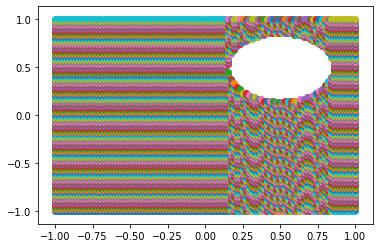

In [21]:
# Risk Contour Example: safe region with offset
x_1 = np.linspace(-1,1,100)
x_2 = np.linspace(-1,1,100)
x1 = Symbol('x1')
x2 = Symbol('x2')

# obstacle equation
g = random_ob(.5,.5)
# risk contour for delta risk level and radius with uniform dist over [l,u]
C = static_rc(g,.5,.3,.4)

for x in x_1:
    for y in x_2:
        C_array = [C[0].subs([(x1, x), (x2, y)]),C[1].subs([(x1, x), (x2, y)])]
        # equation 10
        if (C_array[0] <= .5 and C_array[1] <= 0):
            plt.scatter(x,y)

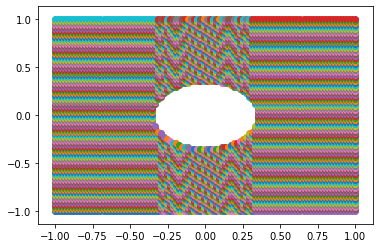

In [8]:
# Risk Contour Example: safe region
x_1 = np.linspace(-1,1,100)
x_2 = np.linspace(-1,1,100)
x1 = Symbol('x1')
x2 = Symbol('x2')

# obstacle equation
g = random_ob()
# risk contour for delta risk level and radius with uniform dist over [l,u]
C = static_rc(g,.5,.3,.4)

for x in x_1:
    for y in x_2:
        C_array = [C[0].subs([(x1, x), (x2, y)]),C[1].subs([(x1, x), (x2, y)])]
        if (C_array[0] <= .5 and C_array[1] <= 0):
            plt.scatter(x,y)

In [137]:
print(type(C[0]))

<class 'sympy.core.mul.Mul'>


### Sample Computations

In [128]:
def compute_simple_risk_contour(x1,x2,delta):
    E_P = 0.1233-x1**2-x2**2
    E_P2 = 0.0156-0.2466*x1**2-0.2466*x2**2+x1**4+2*x1**2*x2**2+x2**4
    C = (E_P2-E_P**2)/E_P2
    
    if C <= delta and E_P<=0:
        return [C,E_P]

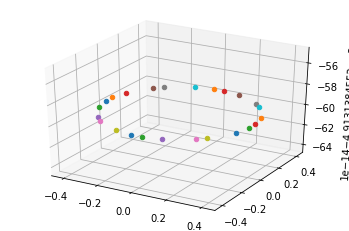

In [129]:
x1 = np.linspace(-1,1,100)
x2 = np.linspace(-1,1,100)
C = []

fig = plt.figure()
ax = plt.axes(projection='3d')

for x in x1:
    for y in x2:
        contour_set = compute_simple_risk_contour(x,y,0.5)
        if contour_set and np.abs(contour_set[1]) > 0.049 and np.abs(contour_set[1]) < .0505:

            ax.scatter3D(x, y, contour_set[1])


In [127]:
compute_simple_risk_contour(.5,.5,.5)

[0.002790653548840521, -0.3767]

In [110]:
def compute_risk_contour(delta,l,u):
    x1 = Symbol('x1')
    x2 = Symbol('x2')
    w = Symbol('w')
    
    # circular obstacle
    g = w**2-x1**2-x2**2
    
    degree = sum(degree_list(g))
    
    # moments for w~Uniform[l,u]
    m_w = [1]
    
    for i in range(2*degree):
        m_w.append((1/(u-l))*((u**(i+1)-l**(i+1))/(i+1)))
        
    # first and second order moments
    Mg = []
    for i in range(1,3):
        Md = simplify(g**i)
        for j in range(i*degree):
            Md = Md.subs(w**j,m_w[1+j])
        Mg.append(Md)
        
    C_1 = (Mg[1]-Mg[0]**2)/Mg[1]
    C_2 = Mg[0]
    
    return [C_1,C_2]

In [111]:
x1 = np.linspace(-1,1,100)
x2 = np.linspace(-1,1,100)
x1 = Symbol('x1')
x2 = Symbol('x2')
C = []

C = compute_risk_contour(.5,.3,.4)
print(C)
print(C[0].subs([(x1, .5), (x2, .5)]))


[(-(-1.0*x1**2 - 1.0*x2**2 + 0.1225)**2 + (x1**2 + x2**2 - 0.1225)**2)/(x1**2 + x2**2 - 0.1225)**2, -1.0*x1**2 - 1.0*x2**2 + 0.1225]
0


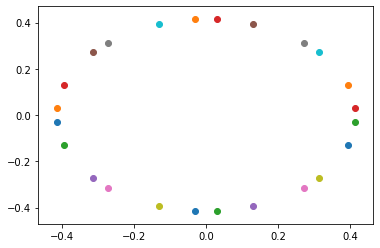

In [113]:
x_1 = np.linspace(-1,1,100)
x_2 = np.linspace(-1,1,100)
x1 = Symbol('x1')
x2 = Symbol('x2')

C = compute_risk_contour(.5,.3,.4)

for x in x_1:
    for y in x_2:
        C_array = [C[0].subs([(x1, x), (x2, y)]),C[1].subs([(x1, x), (x2, y)])]
        if np.abs(C_array[1]) > 0.0495 and np.abs(C_array[1]) < .05005:
            plt.scatter(x,y)

## 3. Continuous-Time Risk Bounded Trajectory Planning using Risk Contours


From part 2, we have formulated conditions for a point $x$ in a trajectory to be safe with the maximum risk of $\Delta$ to collide with uncertain static obstacles as below.

***
$\frac{\mathbb{E}[P^2(x, \omega)] - \mathbb{E}[P(x, \omega)]^2}{\mathbb{E}[P^2(x, \omega)]} \leq \Delta  \land  \mathbb{E}[P(x, \omega)] \leq 0 \$
***

With known momentums of $\omega$, the conditions are polynomial in $x$, and then the feasible set for the trajectory optimization problem can be presented as

***
$\mathcal{S}=\{x: g_i(x) \geq 0 \;\; i=1,\dots,l\}$
***

for some polynomials $g_i$. We are using RRT to find a trajectory in this feasible set to reach the goal state from the initial state. For RRT, we have to define two important functions STEER and ObstacleFree.

### Steer

Given a sampled point and the current state of the RRT tree, steer() finds the node in the RRT tree nearest to the sampled point, and generates a path from that node towards the sampled point (not necessarily ending at the sampled point) in the form of

***
$x(t) = \sum_{i=0}^d c_i t^i \;\; t \in [t_1, t_2]$
***

This path is added as an edge and the endpoint of this path is added as a new node to the RRT tree.



In [ ]:
## Function definition
#
# input
#    tree: current RRT tree
#    endpoint: sampled point towards which the RRT tree needs to grow
#    env: environment representation, including obstacles 
#
# output
#    extended_path: parameters for the extended path
#

def steer(tree, endpoint, env):
    return extended_path

### ObstacleFree

To check the safety of the path defined above, one can use SOS-based continuous-time technique by checking whether each polynomial $g_i(x(t))$ can be represented with SOS polynomials as

***
$g_i(x(t)) = \sigma_{0i}(t) + \sigma_{1i}(t)(t-t_1) + \sigma_{2i}(t)(t_2-t)$
***

where $\sigma_{0i}(t), \sigma_{1i}(t), \sigma_{2i}(t)$ are SOS polynomials. This can be checked using Yalmip and Spotless packages, but for simplicity, we employ an apporximate collision-checking method.

We sample points along the extended path, and check for each point whether it resides in $\mathcal{S}$. By sampling densely enough, we can approximately check if the exented path is free from collision with obstacles.

In [ ]:
## Function definition
#
# input
#    x_nearest: the point closest to x_new
#    x_new: randomly chosen point by RRT
#    env: environment variable used for collision checking
#    radius: the robot radius
#    safety_factor: extra buffering region around the robot
#
# output
#    boolean: True if the temporary trajectory that steer() function generates hits obstacles, otherwise False.
#

def obstacle_free(x_nearest, x_new, env, radius, safety_factor): 
    # check if the newly generated line from x_nearest to x_new is violating the obstacle constraints.
    # put extra buffer around the line and check collisions using the given obstacles by env
    return boolean

### RRT* for trajectory generation

Then, using the functions defined above, we can employ RRT* to generate a trajectory with bounded risk $\Delta$ to collide with uncertain static obstacles.

In [ ]:
## Function definition
#
# input
#    init: initial sate of the robot
#    goal: goal state of the robot
#    env: environment representation, including obstacles
#    radius: the robot radius
#    safety_factor: extra buffering region around the robot
#
# output
#    trajectory: list of successvie paths represented with parameters
#

def generate_trajectory(init, goal, env, radius, safety_factor):
    return trajectory

## Functions for Optimization

As mentioned previously, we will be using the scipy library function *minimize* to solve the problem given by Eq. 2 in Section 1. The use of this function requires the use of two support functions, namely a cost function *cost(xN)* which determines the cost of a given trajectory, and *nonlcon(xN, params)* which checks that the trajectory satisfies the constraints of the problem. The function stubs for these two functions, as well as the main optimization function are summarized below:

In [ ]:
## Function definition
#
# input
#    xN: set of control points being optimized
#
# output
#    cost: the cost value of the control points given by the input
#

def cost(xN): 
    # Determine the cost of the given control points. We plan to use arc length, but may include terms such as
    # the time to execute the trajectory or proximity to uncertain obstacles
    return cost

In [ ]:
## Function definition
#
# input
#    xN: set of control points being optimized
#    params: parameters of the problem. This will include start and end points, information on obstacles and the
#            environment, min allowable distance to obstacles, max and min velocity, max and min angular velocity
#
# output
#    constraints: a vector of the constrained variables associated with the problem. Must be >=0 to be satisfied
#

def nonlcon(xN, params): 
    # derive velocity, angular velocity, and distance to obstacles based on xN
    # constraints = [params.max_vel-vel, vel-params.min_vel, params.max_ang_vel-ang_vel, ang_vel-params.min_ang_vel,
    #                dist-min_dist]
    return constraints

In [ ]:
## Function definition
#
# input
#    x0: initial guess of control points created by generate_trajectory
#    params: parameters of the problem. This will include start and end points, information on obstacles and the
#            environment, min allowable distance to obstacles, max and min velocity, max and min angular velocity
#
# output
#    xN_opt: set of control points representing the Bernstein polynomial approximation to the optimal trajectory
#

def generate_optimal_trajectory(x0, params): 
    # Use minimize function to generate an approximation to the optimal trajectory:
    # xN_opt = minimize(@(x)cost(x),x0,@(x)nonlcon(x,params))
    return xN_opt